In [ ]:
!pip install keras_unet_collection
from keras_unet_collection import models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.0 MB/s eta 0:00:00


In [ ]:
import glob
import cv2
import os
import keras_unet_collection.losses as loss
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from skimage import filters

In [ ]:
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/niharika/suadd23")

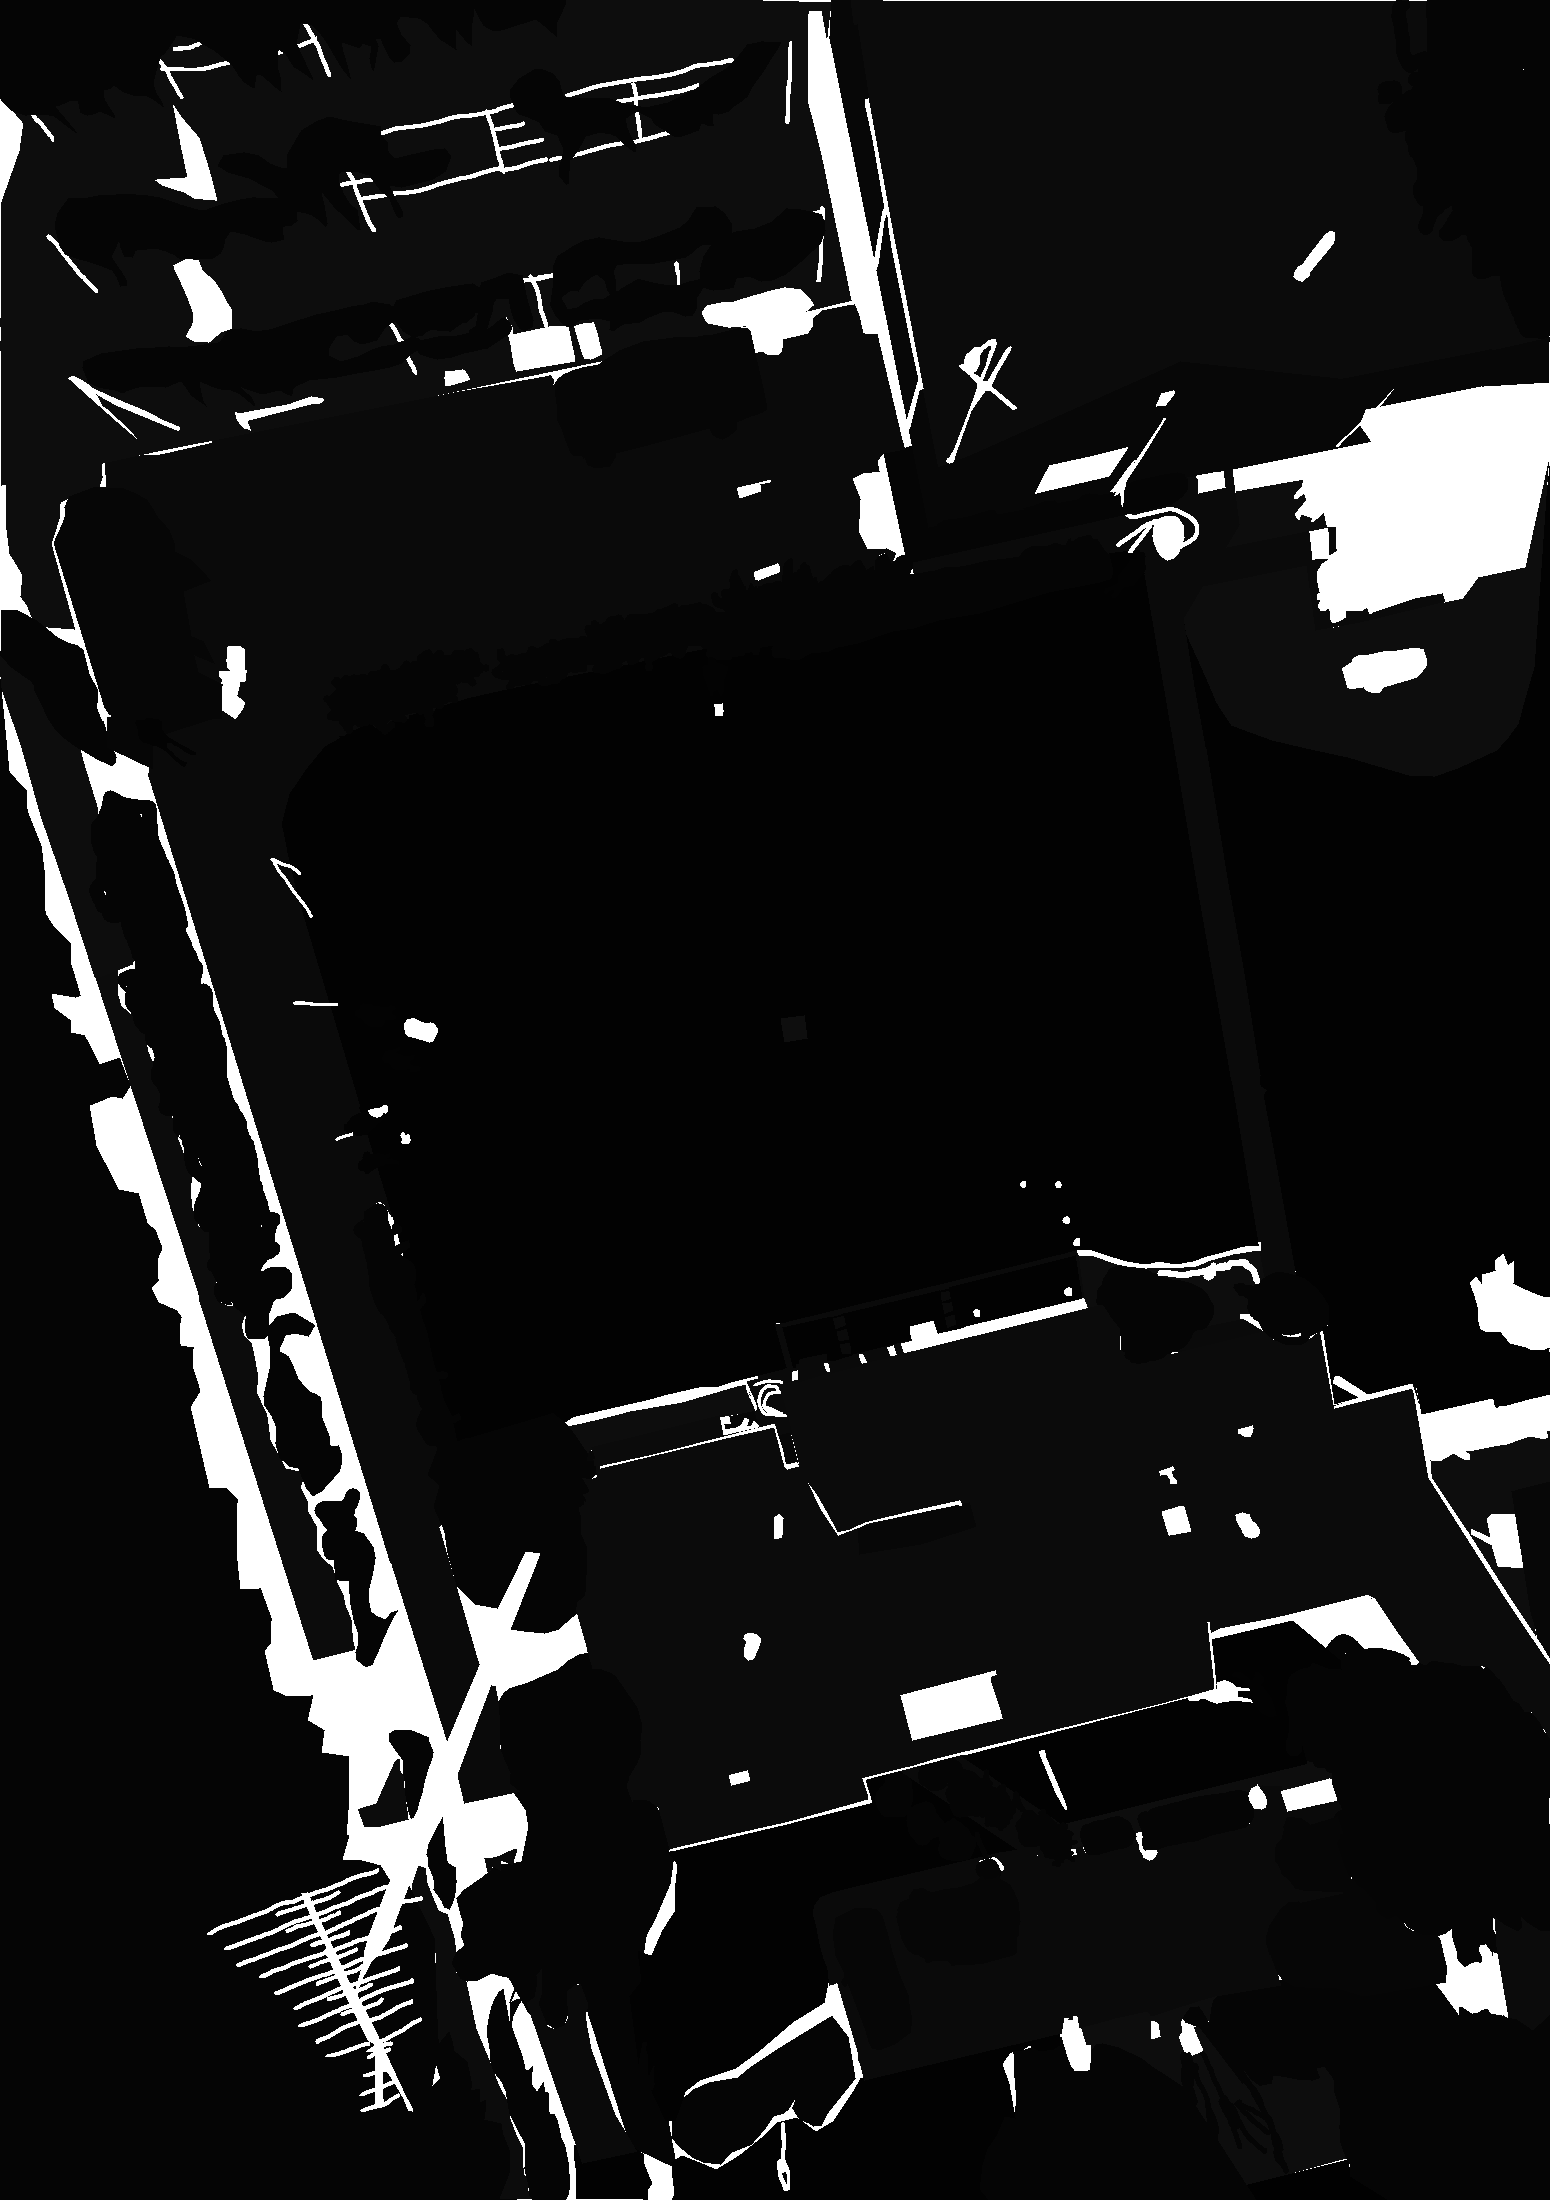

(2200, 1550, 3)
[  1   2   3   5   6   7  10  11  12  13  14 255]


In [ ]:
from google.colab.patches import cv2_imshow
im = cv2.imread("/content/suadd23/semantic_annotations/019c9f9128464ab59a58f2e95f83d55a-1631898858600005621.png")
cv2_imshow(im)
print(im.shape)
print(np.unique(im))

In [ ]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256



#Capture training image info as a list
def load_images(a, b):
  train_image_names = glob.glob("/content/suadd23/inputs/*.png")
  train_mask_names = glob.glob("/content/suadd23/semantic_annotations/*.png")

  train_image_names.sort()
  train_mask_names.sort()

  train_images = [cv2.resize(cv2.imread(img, 0), (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST) for img in train_image_names[a:b]]
  train_masks = [cv2.resize(cv2.imread(msk, 0), (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)  for msk in train_mask_names[a:b]]

  print(np.unique(train_masks[0]))

  train_images = np.array(train_images)

  train_masks = np.array(train_masks)

  return train_images, train_masks

In [ ]:
#RUN TILL HERE FOR BATCH TRAINING

In [ ]:
train_images, train_masks = load_images(200, 400)

[  1   2   3   5   6   7   8   9  10  11  12  13  14 255]


In [ ]:
train_masks.shape

(200, 256, 256)

In [ ]:
print(np.unique(train_masks))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15 255]


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
n, h, w = train_masks.shape
reshaped = train_masks.reshape(-1, 1)
reshaped_encode = le.fit_transform(reshaped)
encoded = reshaped_encode.reshape(n, h, w)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
n_classes = len(np.unique(encoded))
encoded = np.expand_dims(encoded, axis=3)
encoded.shape

(200, 256, 256, 1)

In [ ]:
from keras.utils import to_categorical
train_masks_cat = to_categorical(encoded, num_classes = n_classes)
train_masks_cat = train_masks_cat.reshape(n, h, w, n_classes)

In [ ]:
train_masks_cat.shape

(200, 256, 256, 17)

In [ ]:
from google.colab.patches import cv2_imshow

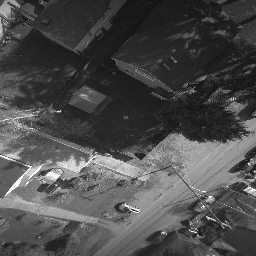

In [ ]:
cv2_imshow(train_images[0])

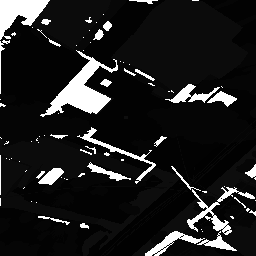

In [ ]:
cv2_imshow(train_masks[0])

In [ ]:
print(train_images[0])
print(train_masks[0])

[[61 61 82 ... 52 51 52]
 [55 99 62 ... 45 48 51]
 [94 66 67 ... 47 48 52]
 ...
 [80 45 58 ... 48 47 46]
 [52 47 70 ... 47 49 50]
 [63 61 64 ... 50 49 35]]
[[255 255 255 ...   2   2   2]
 [255 255 255 ...   2   2   2]
 [255 255 255 ...   2   2   2]
 ...
 [  5   5   5 ...  11  11  11]
 [  5   5   5 ...  11  11  11]
 [  5   5   5 ...  11  11  11]]


In [ ]:
#RUN THIS CODE COMPULSORY EVEN WITH BATCH TRAINING

In [ ]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import keras
import keras.backend as K

In [ ]:
def IoU(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    intersection = K.dot(K.transpose(targets), inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection

    IoU = (intersection + smooth) / (union + smooth)
    return IoU

In [ ]:
def lossIoU(targets, inputs, smooth=1e-6):

    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    intersection = K.dot(K.transpose(targets), inputs)
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection

    IoU = (intersection + smooth) / (union + smooth)
    return 1-IoU

In [ ]:
# Import necessary modules
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.layers import Lambda
from keras.optimizers import Adam
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Conv2DTranspose

# Define the input shape and number of classes
input_shape = (256, 256, 1)
n_classes = 17

# Define the base U-Net architecture
def unet(input_shape, n_classes):
    # Encoder
    inputs = Input(input_shape)
    x = inputs
    conv_blocks = []
    for i, f in enumerate([64, 128, 256, 512]):
        for j in range(2):
            x = Conv2D(f, 3, padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        conv_blocks.append(x)
        if i < len([64, 128, 256, 512]) - 1:
            x = MaxPooling2D(pool_size=(2, 2))(x)

    # Decoder
    for i, f in enumerate([256, 128, 64]):
        x = Conv2DTranspose(f, 2, strides=(2, 2), padding='same')(x)
        x = concatenate([x, conv_blocks[-(i + 2)]])
        for j in range(2):
            x = Conv2D(f, 3, padding='same', kernel_initializer='he_normal')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    # Output
    outputs = Conv2D(n_classes, 1, activation='softmax')(x)

    model = Model(inputs, outputs, name='unet')
    return model

# Define the Pyramid Pooling Module (PPM)
def pyramid_pooling_module(input_tensor, bin_sizes):
    concat_list = [input_tensor]
    H = input_tensor.shape[1]
    W = input_tensor.shape[2]

    for bin_size in bin_sizes:
        x = MaxPooling2D(pool_size=(H//bin_size, W//bin_size), strides=(H//bin_size, W//bin_size))(input_tensor)
        x = Conv2D(64, kernel_size=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Lambda(lambda x: K.tf.image.resize(x, (H, W)))(x)
        concat_list.append(x)

    return Concatenate()(concat_list)

# Define the full PSPNet modelfrom tensorflow.keras.optimizers import Adam

# Define the PSPNet model
def pspnet(input_shape, n_classes):
    # Define the base U-Net architecture
    inputs = Input(input_shape)
    base_model = unet(input_shape, n_classes)
    x = base_model(inputs)

    # Add Pyramid Pooling Module
    bin_sizes = [1, 2, 3, 6]
    x = pyramid_pooling_module(x, bin_sizes)

    # Output
    outputs = Conv2D(n_classes, 1, activation='softmax')(x)

    # Compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=1e-4),
                  loss=lossIoU,
                  metrics=IoU)

    return model




In [ ]:
model = pspnet((256, 256, 1), 17)
print(model)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 unet (Functional)              (None, 256, 256, 17  7708497     ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_38 (MaxPooling2D  (None, 1, 1, 17)    0           ['unet[0][0]']                   
 )                                                                                          

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#TILL HERE

In [ ]:
X = train_images[:200]
Y = train_masks_cat[:200]
print(X.shape, Y.shape)

# Y = np.expand_dims(Y, axis=3)


from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=12)

(200, 256, 256) (200, 256, 256, 17)


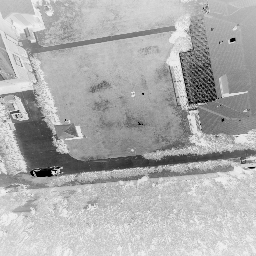

In [ ]:
cv2_imshow(x_val[20]*255)


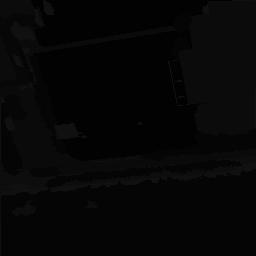

In [ ]:
cv2_imshow(np.argmax(y_val[20], axis=2))

In [ ]:
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=25,
   verbose=1,
   validation_data=(x_val, y_val)
)

Epoch 1/25
10/10 [==============================] - 10s 966ms/step - loss: 1.3688 - accuracy: 0.5491 - val_loss: 2.2198 - val_accuracy: 0.3543
Epoch 2/25
10/10 [==============================] - 9s 921ms/step - loss: 1.3390 - accuracy: 0.5651 - val_loss: 2.1926 - val_accuracy: 0.3400
Epoch 3/25
10/10 [==============================] - 10s 995ms/step - loss: 1.2969 - accuracy: 0.5806 - val_loss: 2.1808 - val_accuracy: 0.3400
Epoch 4/25
10/10 [==============================] - 9s 929ms/step - loss: 1.2623 - accuracy: 0.5937 - val_loss: 2.1327 - val_accuracy: 0.3853
Epoch 5/25
10/10 [==============================] - 9s 939ms/step - loss: 1.2350 - accuracy: 0.5977 - val_loss: 2.1065 - val_accuracy: 0.3762
Epoch 6/25
10/10 [==============================] - 10s 979ms/step - loss: 1.2214 - accuracy: 0.6005 - val_loss: 2.0952 - val_accuracy: 0.3905
Epoch 7/25
10/10 [==============================] - 9s 941ms/step - loss: 1.1834 - accuracy: 0.6182 - val_loss: 1.9992 - val_accuracy: 0.4366
Epo

In [ ]:
loss, val_loss, acc, val_acc = [], [], [], []

In [ ]:
#RUN THIS CELL AT THE END OF BATCH TRAINING, UNCOMMENT ALL IF NOT BATCH TRAINING

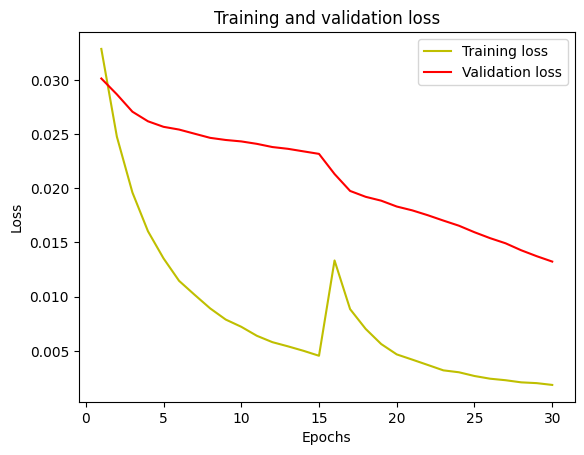

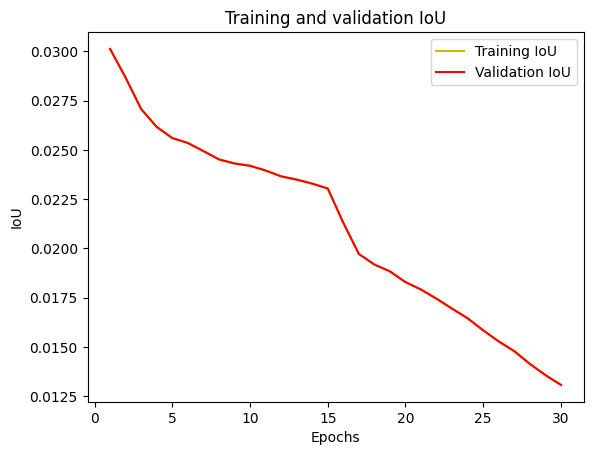

In [ ]:
# loss.extend(history.history['loss'])
# val_loss.extend(history.history['val_loss'])
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# acc.extend(history.history['IoU'])
# val_acc.extend(history.history['val_IoU'])

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

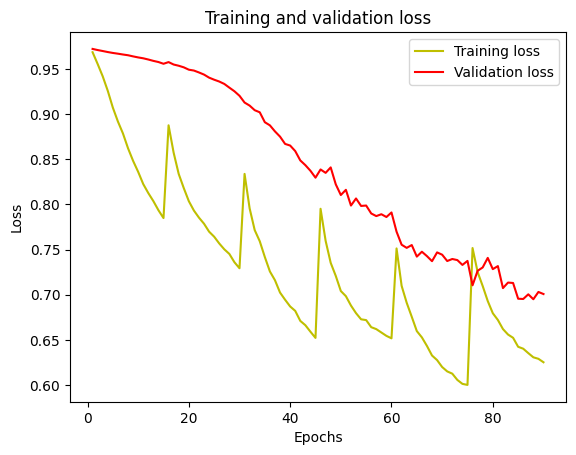

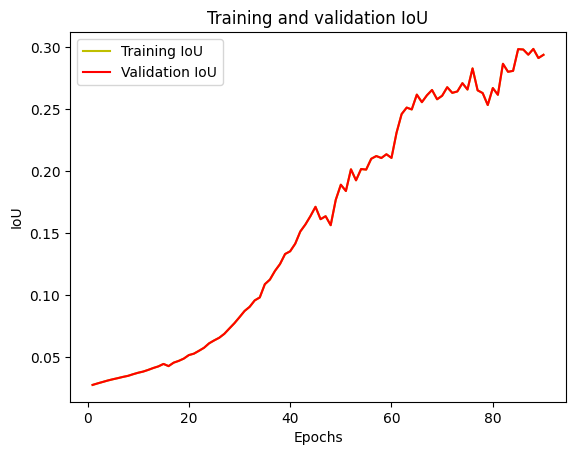

In [ ]:
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# acc.extend(history.history['IoU'])
# val_acc.extend(history.history['val_IoU'])

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(x_val)

2/2 [==============================] - 14s 22ms/step


In [ ]:
print(y_pred.shape)
y_pred_argmax=np.argmax(y_pred, axis=3)
print(y_pred_argmax.shape)

(40, 256, 256, 17)
(40, 256, 256)


39
1/1 [==============================] - 0s 47ms/step


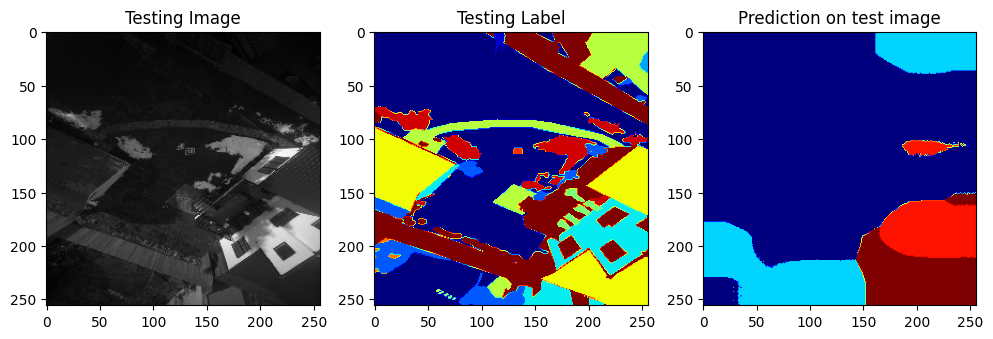

In [ ]:
import random
test_img_number = random.randint(0, len(x_val)-1)
# test_img_number = 9
print(test_img_number)
test_img = x_val[test_img_number]
ground_truth=y_val[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(np.argmax(ground_truth, axis = 2), cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [ ]:
model.save("sUadd1.h5")

In [ ]:
model = keras.models.load_model("sUadd.h5", custom_objects={ 'IoU':IoU})

In [ ]:
train_images, train_masks = 0, 0

In [ ]:
#AUTO RUN CODE FOR MULTIPLE BATCH TESTING

[  1   2   3   5   6   7  10  11  12  13  14 255]
Loading images for batch 0 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 0 started
Epoch 1/15
10/10 [==============================] - 11s 1s/step - loss: 0.7318 - IoU: 0.2682 - val_loss: 0.7659 - val_IoU: 0.2395
Epoch 2/15
10/10 [==============================] - 11s 1s/step - loss: 0.6979 - IoU: 0.3021 - val_loss: 0.7350 - val_IoU: 0.2741
Epoch 3/15
10/10 [==============================] - 11s 1s/step - loss: 0.6748 - IoU: 0.3252 - val_loss: 0.7330 - val_IoU: 0.2757
Epoch 4/15
10/10 [==============================] - 10s 1s/step - loss: 0.6560 - IoU: 0.3440 - val_loss: 0.7300 - val_IoU: 0.2789
Epoch 5/15
10/10 [==============================] - 10s 1s/step - loss: 0.6481 - IoU: 0.3519 - val_loss: 0.7220 - val_IoU: 0.2878
Epoch 6/15
10/10 [==============================] - 10s 998ms/step - loss: 0.6399 - IoU: 0.3601 - val_loss: 0.7311 - val_IoU: 0.2778
Epoch 7/15
10/10 [==============================] - 10s 999ms/step - loss: 0.6338 - IoU: 0.3662 - val_loss: 0.7246 - val_IoU: 0.2853
Epoch 8/15
10/10 [==============================]

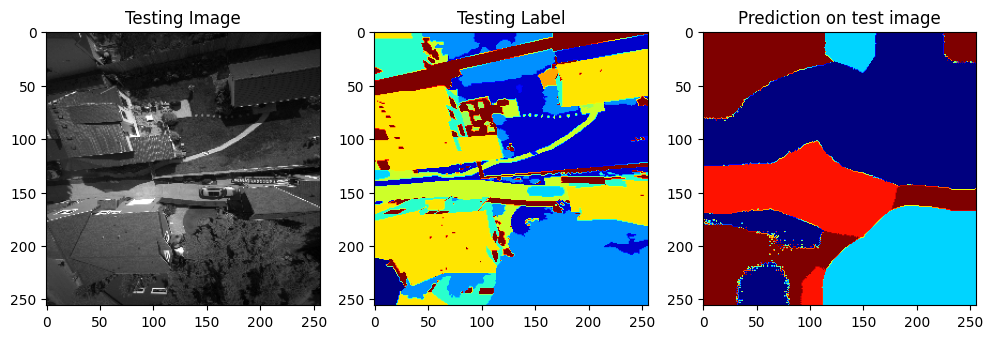

[  1   2   3   5   6   7   8   9  10  11  12  13  14 255]
Loading images for batch 1 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 1 started
Epoch 1/15
10/10 [==============================] - 11s 1s/step - loss: 0.7326 - IoU: 0.2674 - val_loss: 0.7482 - val_IoU: 0.2544
Epoch 2/15
10/10 [==============================] - 11s 1s/step - loss: 0.6930 - IoU: 0.3070 - val_loss: 0.7352 - val_IoU: 0.2649
Epoch 3/15
10/10 [==============================] - 11s 1s/step - loss: 0.6769 - IoU: 0.3231 - val_loss: 0.7350 - val_IoU: 0.2638
Epoch 4/15
10/10 [==============================] - 10s 1s/step - loss: 0.6607 - IoU: 0.3393 - val_loss: 0.7370 - val_IoU: 0.2622
Epoch 5/15
10/10 [==============================] - 10s 1s/step - loss: 0.6442 - IoU: 0.3558 - val_loss: 0.7369 - val_IoU: 0.2624
Epoch 6/15
10/10 [==============================] - 10s 1s/step - loss: 0.6380 - IoU: 0.3620 - val_loss: 0.7298 - val_IoU: 0.2694
Epoch 7/15
10/10 [==============================] - 10s 994ms/step - loss: 0.6309 - IoU: 0.3691 - val_loss: 0.7308 - val_IoU: 0.2688
Epoch 8/15
10/10 [==============================] - 

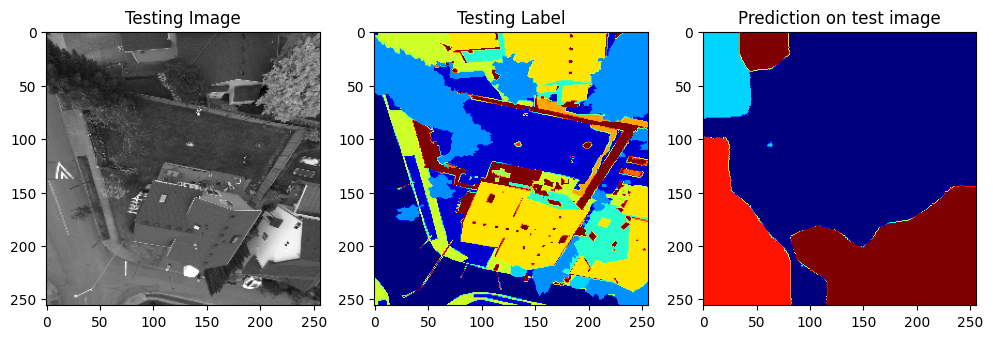

[  2   3   5   6   7  10  11  12  13  14 255]
Loading images for batch 2 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 2 started
Epoch 1/15
10/10 [==============================] - 11s 1s/step - loss: 0.7015 - IoU: 0.2985 - val_loss: 0.6911 - val_IoU: 0.3094
Epoch 2/15
10/10 [==============================] - 11s 1s/step - loss: 0.6744 - IoU: 0.3256 - val_loss: 0.7027 - val_IoU: 0.2996
Epoch 3/15
10/10 [==============================] - 11s 1s/step - loss: 0.6459 - IoU: 0.3541 - val_loss: 0.6943 - val_IoU: 0.3076
Epoch 4/15
10/10 [==============================] - 10s 1s/step - loss: 0.6233 - IoU: 0.3767 - val_loss: 0.6922 - val_IoU: 0.3079
Epoch 5/15
10/10 [==============================] - 10s 1s/step - loss: 0.6134 - IoU: 0.3866 - val_loss: 0.7099 - val_IoU: 0.2916
Epoch 6/15
10/10 [==============================] - 10s 1s/step - loss: 0.6017 - IoU: 0.3983 - val_loss: 0.6917 - val_IoU: 0.3083
Epoch 7/15
10/10 [==============================] - 10s 1s/step - loss: 0.5955 - IoU: 0.4045 - val_loss: 0.6969 - val_IoU: 0.3040
Epoch 8/15
10/10 [==============================] - 10s

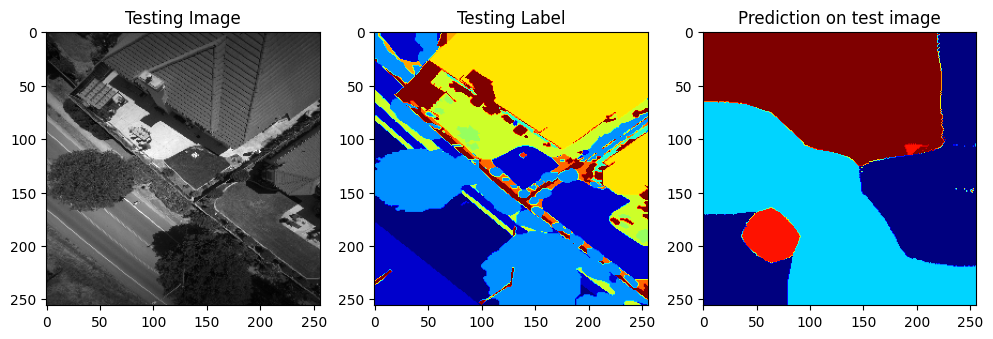

[  1   2   3   5   6   7   9  10  11  14 255]
Loading images for batch 3 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 3 started
Epoch 1/15
10/10 [==============================] - 10s 1s/step - loss: 0.6999 - IoU: 0.3001 - val_loss: 0.7439 - val_IoU: 0.2526
Epoch 2/15
10/10 [==============================] - 11s 1s/step - loss: 0.6668 - IoU: 0.3332 - val_loss: 0.7464 - val_IoU: 0.2505
Epoch 3/15
10/10 [==============================] - 11s 1s/step - loss: 0.6569 - IoU: 0.3431 - val_loss: 0.7367 - val_IoU: 0.2602
Epoch 4/15
10/10 [==============================] - 10s 1s/step - loss: 0.6428 - IoU: 0.3572 - val_loss: 0.7441 - val_IoU: 0.2547
Epoch 5/15
10/10 [==============================] - 10s 1s/step - loss: 0.6307 - IoU: 0.3693 - val_loss: 0.7241 - val_IoU: 0.2707
Epoch 6/15
10/10 [==============================] - 10s 1s/step - loss: 0.6222 - IoU: 0.3778 - val_loss: 0.7175 - val_IoU: 0.2785
Epoch 7/15
10/10 [==============================] - 10s 1s/step - loss: 0.6157 - IoU: 0.3843 - val_loss: 0.7288 - val_IoU: 0.2692
Epoch 8/15
10/10 [==============================] - 10s

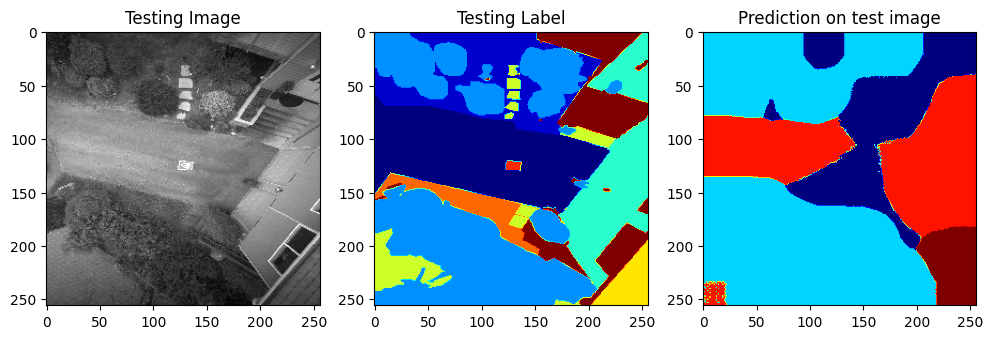

[  2   3   5   7   9  10  11  12  13  14 255]
Loading images for batch 4 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 4 started
Epoch 1/15
10/10 [==============================] - 10s 1s/step - loss: 0.6705 - IoU: 0.3295 - val_loss: 0.6908 - val_IoU: 0.3101
Epoch 2/15
10/10 [==============================] - 10s 1s/step - loss: 0.6417 - IoU: 0.3583 - val_loss: 0.6902 - val_IoU: 0.3102
Epoch 3/15
10/10 [==============================] - 11s 1s/step - loss: 0.6238 - IoU: 0.3762 - val_loss: 0.6989 - val_IoU: 0.3040
Epoch 4/15
10/10 [==============================] - 11s 1s/step - loss: 0.6118 - IoU: 0.3882 - val_loss: 0.6780 - val_IoU: 0.3239
Epoch 5/15
10/10 [==============================] - 10s 1s/step - loss: 0.6045 - IoU: 0.3955 - val_loss: 0.6763 - val_IoU: 0.3268
Epoch 6/15
10/10 [==============================] - 10s 1s/step - loss: 0.5869 - IoU: 0.4131 - val_loss: 0.6801 - val_IoU: 0.3243
Epoch 7/15
10/10 [==============================] - 10s 1s/step - loss: 0.5785 - IoU: 0.4215 - val_loss: 0.6720 - val_IoU: 0.3306
Epoch 8/15
10/10 [==============================] - 10s

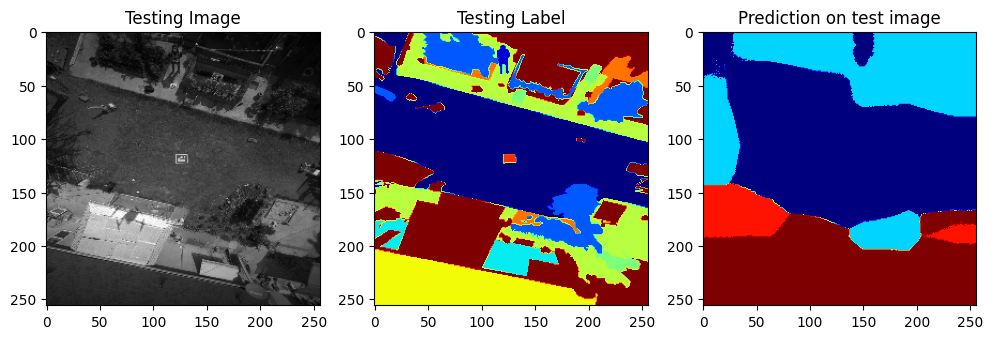

[  2   3   5   7   9  10  11  12  13  14 255]
Loading images for batch 5 completed


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training model for batch 5 started
Epoch 1/15
10/10 [==============================] - 10s 1s/step - loss: 0.6896 - IoU: 0.3104 - val_loss: 0.6871 - val_IoU: 0.3048
Epoch 2/15
10/10 [==============================] - 10s 1s/step - loss: 0.6641 - IoU: 0.3359 - val_loss: 0.6780 - val_IoU: 0.3142
Epoch 3/15
10/10 [==============================] - 11s 1s/step - loss: 0.6398 - IoU: 0.3602 - val_loss: 0.6880 - val_IoU: 0.3080
Epoch 4/15
10/10 [==============================] - 11s 1s/step - loss: 0.6299 - IoU: 0.3701 - val_loss: 0.6572 - val_IoU: 0.3350
Epoch 5/15
10/10 [==============================] - 11s 1s/step - loss: 0.6221 - IoU: 0.3779 - val_loss: 0.6817 - val_IoU: 0.3131
Epoch 6/15
10/10 [==============================] - 11s 1s/step - loss: 0.6133 - IoU: 0.3867 - val_loss: 0.6575 - val_IoU: 0.3343
Epoch 7/15
10/10 [==============================] - 10s 1s/step - loss: 0.6117 - IoU: 0.3883 - val_loss: 0.6660 - val_IoU: 0.3274
Epoch 8/15
10/10 [==============================] - 10s

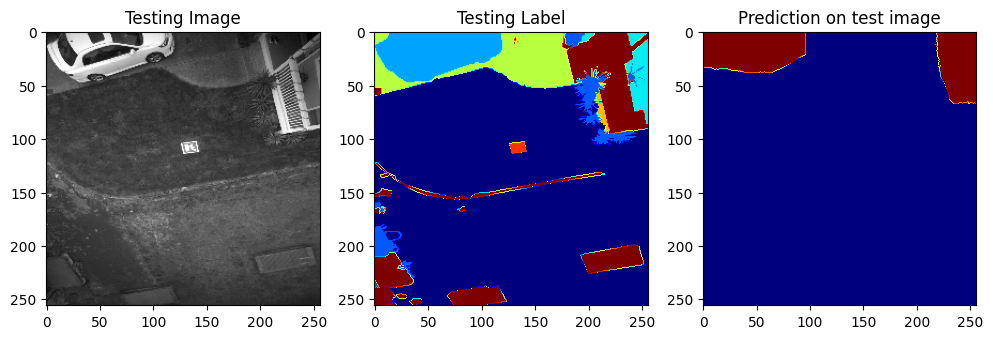

In [ ]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
loss, val_loss, acc, val_acc = [], [], [], []
SIZE_Y = 256
batch_start = 0
batch_end = 1200
batch_size = 200
for batch in range(batch_start, batch_end, batch_size):
  train_images,  train_masks =  load_images(batch, batch+batch_size)
  print(f"Loading images for batch {(batch-batch_start)//batch_size} completed")

  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  n, h, w = train_masks.shape
  reshaped = train_masks.reshape(-1, 1)
  reshaped_encode = le.fit_transform(reshaped)
  encoded = reshaped_encode.reshape(n, h, w)

  n_classes = len(np.unique(encoded))
  encoded = np.expand_dims(encoded, axis=3)

  from keras.utils import to_categorical
  train_masks_cat = to_categorical(encoded, num_classes = n_classes)
  train_masks_cat = train_masks_cat.reshape(n, h, w, n_classes)

  X = train_images[:200]
  Y = train_masks_cat[:200]

  from sklearn.model_selection import train_test_split
  x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=12)

  print(f"Training model for batch {(batch-batch_start)//batch_size} started")
  history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=16,
   epochs=15,
   verbose=1,
   validation_data=(x_val, y_val)
  )

  print(f"Training model for batch {(batch-batch_start)//batch_size} completed")

  acc.extend(history.history['val_IoU'])
  val_acc.extend(history.history['val_IoU'])
  loss.extend(history.history['loss'])
  val_loss.extend(history.history['val_loss'])

  import random
  # test_img_number = random.randint(0, len(x_val)-1)
  test_img_number = 18
  print(f"Test image number: {test_img_number}, Batch number: {(batch-batch_start)//batch_size}")
  test_img = x_val[test_img_number]
  ground_truth=y_val[test_img_number]
  # test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]

  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img, cmap='gray')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(np.argmax(ground_truth, axis = 2), cmap='jet')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img, cmap='jet')
  plt.show()